In [43]:
import numpy as np
import time
from pynq import Overlay, Xlnk
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl

np.set_printoptions(suppress=True)
mpl.rcParams['axes.unicode_minus'] = False  # 显示负号
# help(time)

### 产生待处理的信号

In [44]:
# 采样点选择2048个，因为设置的信号频率分量最高为600赫兹，根据采样定理知采样频率要大于信号频率2倍，所以这里设置采样频率为2048赫兹（即一秒内有2048个采样点，一样意思的）
x = np.linspace(0, 1, 2048)

# 设置需要采样的信号，频率分量有200，400和600
y = 7 * np.sin(2 * np.pi * 200 * x) + 5 * np.sin(2 * np.pi * 400 * x) + 3 * np.sin(2 * np.pi * 600 * x)

### 软件方法计算频谱及可视化

In [45]:
start = time.time()
fft_y = fft(y)  # 快速傅里叶变换
end = time.time()
print('FFT caculated by cpu wastes  %d us' %((end-start)*1000000))

FFT caculated by cpu wastes  2897 us


In [46]:
N = 2048
x = np.arange(N)  # 频率个数
half_x = x[range(int(N / 2))]  # 取一半区间

In [47]:
abs_y = np.abs(fft_y)  # 取复数的绝对值，即复数的模(双边频谱)
normalization_y = abs_y / N  # 归一化处理（双边频谱）
normalization_half_y = normalization_y[range(int(N / 2))]  # 由于对称性，只取一半区间（单边频谱）

### 绘制原始波形

Text(0.5,1,'Original waveform')

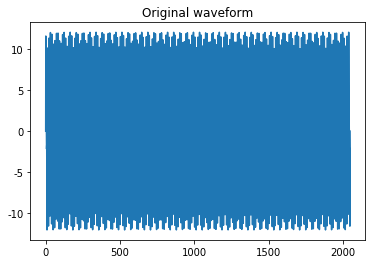

In [48]:
plt.plot(x, y)
plt.title('Original waveform')

### 未归一化的双边振幅谱

Text(0.5,1,'Bilateral amplitude spectrum (not normalized)')

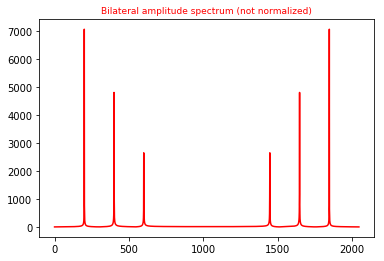

In [49]:
plt.plot(x, abs_y, 'r')
plt.title('Bilateral amplitude spectrum (not normalized)', fontsize=9, color='red')

### 归一化的双边振幅谱

Text(0.5,1,'Bilateral amplitude spectrum (normalized)')

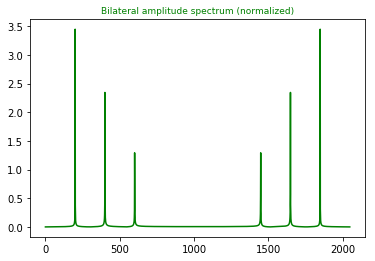

In [50]:
plt.plot(x, normalization_y, 'g')
plt.title('Bilateral amplitude spectrum (normalized)', fontsize=9, color='green')

### 归一化的单边振幅谱

Text(0.5,1,'Unilateral amplitude spectrum (normalized)')

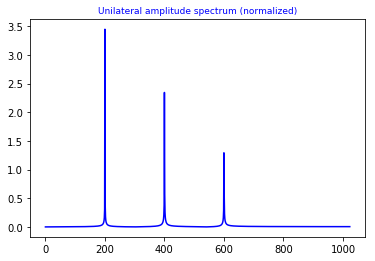

In [51]:
plt.plot(half_x, normalization_half_y, 'blue')
plt.title('Unilateral amplitude spectrum (normalized)', fontsize=9, color='blue')

### 调用硬件进行频谱计算

In [52]:
# x = np.loadtxt("wave.txt", dtype=np.float32)
TWO_TO_THE_POWER_OF_N_MAX = 11
NFFT = 1 << TWO_TO_THE_POWER_OF_N_MAX

In [53]:
overlay = Overlay("fft.bit")
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(NFFT,), dtype=np.csingle)
out_buffer = xlnk.cma_array(shape=(NFFT,), dtype=np.csingle)
data = y[:NFFT].astype(np.csingle)

#overlay = Overlay("fft_float_pynq_z1.bit")
#in_buffer = xlnk.cma_array(shape=(NFFT,), dtype=np.float32)
#out_buffer = xlnk.cma_array(shape=(NFFT*2,), dtype=np.float32)
#data = x[:NFFT].astype(np.float32)

fft_ip = overlay.hls_fft_0
dma_ip = overlay.axi_dma_0

fft_ip.write(0x10, TWO_TO_THE_POWER_OF_N_MAX)

In [54]:
start = time.time()
def fft_on_hw(fft_ip, dma_ip, input_data):    
    Xlnk.cma_memcopy(in_buffer, input_data, in_buffer.data.nbytes)
    dma_ip.sendchannel.transfer(in_buffer)
    dma_ip.recvchannel.transfer(out_buffer)
    fft_ip.write(0x00, 0x01)
    while not ((fft_ip.read(0x00) >> 1) & 0x01):
        continue
    dma_ip.sendchannel.wait()
    dma_ip.recvchannel.wait() 
    return out_buffer.copy()

end = time.time()
print('FFT caculated by FPGA wastes  %d us' %((end-start)*1000000))

FFT caculated by FPGA wastes  1662 us


In [55]:
result = fft_on_hw(fft_ip, dma_ip, data)

### 归一化的单边振幅谱（FPGA计算）

Text(0.5,1,'Unilateral amplitude spectrum (normalized) with hardware')

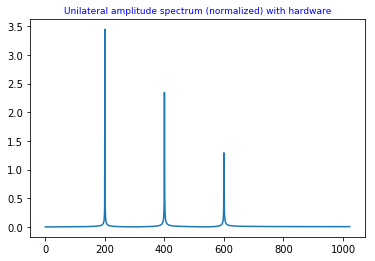

In [56]:
plt.plot(np.arange(NFFT/2),np.abs(result[range(int(NFFT/2))])/NFFT)
plt.title('Unilateral amplitude spectrum (normalized) with hardware', fontsize=9, color='blue')